In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import numpy as np

In [96]:
data = pd.read_excel('data.xlsx')

In [97]:
fraud_data = pd.read_csv('fraud_data.csv', index_col='Unnamed: 0')

### 1. Ворононки продаж для фродов и пользователей

In [98]:
steps = ['interest', 'consideration', 'intent', 'purchase']
users_dict = {}
for step in steps:
    users_dict[step] = data.groupby(by = ['funnel_stage'])['user_id'].count().to_dict().get(step)
users_df = pd.DataFrame(users_dict.values(), index=users_dict.keys(), columns=['count_users'])

frauds_dict = {}
for step in steps:
    frauds_dict[step] = fraud_data.groupby(by = ['funnel_stage'])['user_id'].count().to_dict().get(step)
fraud_df = pd.DataFrame(frauds_dict.values(), index=frauds_dict.keys(), columns=['count_frauds']).fillna(0)

users_fraud = pd.concat([users_df, fraud_df], axis=1).reset_index()
users_fraud

,index,count_users,count_frauds
0,interest,592863,2580591.0
1,consideration,338293,0.0
2,intent,50896,226642.0
3,purchase,4834,0.0


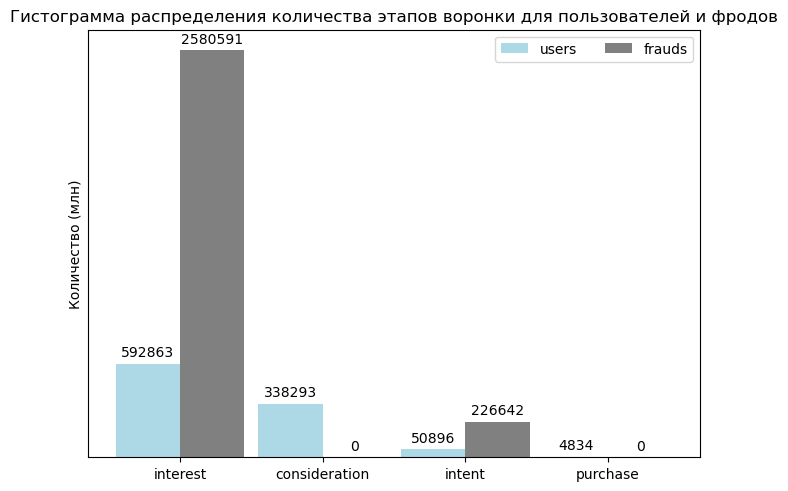

In [102]:
steps = users_fraud['index'].to_list()
data_columns = {
    'users': users_fraud.count_users.to_list(),
    'frauds': users_fraud.count_frauds.to_list(),
    }
colors=['lightblue', 'gray']

x = np.arange(len(steps)) 
width = 0.45  
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for column, value in data_columns.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, value, width, label=column, color=colors[multiplier])
    ax.bar_label(rects, padding=3, fmt='%.0d')
    multiplier += 1

ax.set_ylabel('Количество (млн)')
ax.set_title('Гистограмма распределения количества этапов воронки для пользователей и фродов')
ax.set_xticks(x + 0.5*width, steps)
ax.set_yticks([])
ax.legend(loc='upper right', ncols=2)


plt.show()

#### Вывод

Заметно, что frauds есть в 2х этапах: interest и intent, это логично, так как на этих этапах можно много раз кликать на рекламу, переходить по ссылкам, добавлять в корзину и таким образом повышать значения. Невозможно так сделать для purchase - нужно осуществить покупку 

### 2. Воронки продаж по каналам продаж

In [140]:
ad_channel = data.groupby(['ad_channel', 'funnel_stage'], as_index=False)['user_id'].count().sort_values(
    by=['ad_channel','user_id'], ascending=False)
ad_channel

,ad_channel,funnel_stage,user_id
26,video,interest,98459
24,video,consideration,60880
25,video,intent,58
27,video,purchase,5
22,search,interest,227162
20,search,consideration,134305
21,search,intent,27980
23,search,purchase,3090
18,rich,interest,8922
16,rich,consideration,4657


In [237]:
for i in ad_channel[ad_channel.funnel_stage=='interest'].sort_values(by=['user_id'], ascending=False).ad_channel.to_list():
    print(i, ad_channel[ad_channel.ad_channel==i].user_id.to_list())

search [227162, 134305, 27980, 3090]
video [98459, 60880, 58, 5]
banner [92502, 47541, 7625, 688]
organic_traffic [79205, 53592, 9163, 542]
partner_network [66733, 24721, 4420, 450]
native [19880, 12597, 412, 37]
rich [8922, 4657, 1238, 22]


In [239]:
fig = go.Figure()

fig.add_trace(go.Funnelarea(
    values = [227162, 134305, 27980, 3090], textinfo = "value+percent",
    title = {"position": "top center", "text": "search"},
    domain = {"x": [0, 0.25], "y": [0.5, 1]}, labels=['interest', 'consideration', 'intent', 'purchase']))

fig.add_trace(go.Funnelarea(
    values = [98459, 60880, 58, 5], textinfo = "value+percent",
    title = {"position": "top center", "text": "video"},
    domain = {"x": [0.25, 0.5], "y": [0.5, 1]}, labels=['interest', 'consideration', 'intent', 'purchase']))

fig.add_trace(go.Funnelarea(
    values = [92502, 47541, 7625, 688], textinfo = "value+percent",
    title = {"position": "top center", "text": "banner"},
    domain = {"x": [0.5, 0.75], "y": [0.5, 1]}, labels=['interest', 'consideration', 'intent', 'purchase']))

fig.add_trace(go.Funnelarea(
    values = [79205, 53592, 9163, 542], textinfo = "value+percent",
    title = {"position": "top center", "text": "organic_traffic"},
    domain = {"x": [0.75, 1], "y": [0.5, 1]}, labels=['interest', 'consideration', 'intent', 'purchase']))

fig.add_trace(go.Funnelarea(
    values = [66733, 24721, 4420, 450], textinfo = "value+percent",
    title = {"position": "top center", "text": "partner_network"},
    domain = {"x": [0, 0.25], "y": [0, 0.5]}, labels=['interest', 'consideration', 'intent', 'purchase']))

fig.add_trace(go.Funnelarea(
    values = [19880, 12597, 412, 37], textinfo = "value+percent",
    title = {"position": "top center", "text": "native"},
    domain = {"x": [0.25, 0.5], "y": [0, 0.5]}, labels=['interest', 'consideration', 'intent', 'purchase']))

fig.add_trace(go.Funnelarea(
    values = [8922, 4657, 1238, 22],textinfo = "value+percent", 
    title = {"position": "top center", "text": "rich"},
    domain = {"x": [0.5, 0.75], "y": [0, 0.5]}, labels=['interest', 'consideration', 'intent', 'purchase']))


fig.update_layout(
            margin=dict(l=0, r=0, t=0, b=0), shapes = [
            {"x0": 0, "x1": 0.25, "y0": 0, "y1": 0.5},
            {"x0": 0.25, "x1": 0.5, "y0": 0, "y1": 0.5},
            {"x0": 0.5, "x1": 0.75, "y0": 0, "y1": 0.5},
            {"x0": 0.75, "x1": 1, "y0": 0, "y1": 0.5},
            {"x0": 0, "x1": 0.25, "y0": 0.5, "y1": 1},
            {"x0": 0.25, "x1": 0.5, "y0": 0.5, "y1": 1},
            {"x0": 0.5, "x1": 0.75, "y0": 0.5, "y1": 1}])
fig.update_shapes(line=dict(color='grey', width=0.2))

fig.show()

#### Вывод

Наименее перспективным кажется канал video - только 5 покупок из 98 тысяч пользователей в начале воронки, это 0,00314 % от первого этапа. Для всех остальных каналов показатели значительно выше 

### 3. Гграфики затрат для каждого рекламного канала и прибыли по ним на последнем этапе воронки

In [245]:
df_profit_price = data.groupby(['ad_channel'])[['profit', 'price']].sum().sort_values(by='profit', ascending=False)
df_profit_price

,profit,price
ad_channel,,
search,2112193,588805.5
banner,497881,74178.0
partner_network,445411,96324.0
organic_traffic,367094,0.0
native,37355,65852.0
rich,33511,37097.5
video,4582,119551.5


In [271]:
df_profit_price.index.to_list()

['search',
 'banner',
 'partner_network',
 'organic_traffic',
 'native',
 'rich',
 'video']

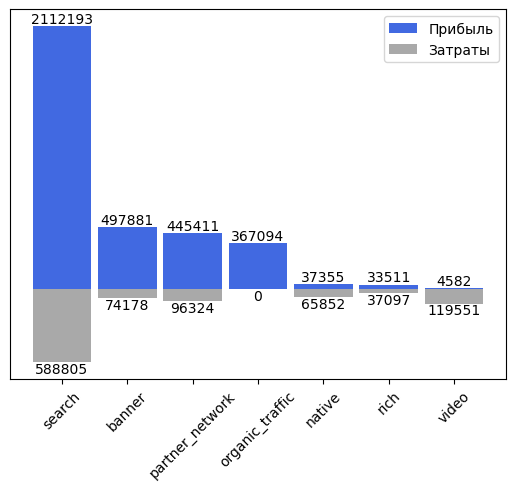

In [306]:
x0 = df_profit_price.index.to_list()
y1 = np.array(df_profit_price.profit.to_list())
y2 = np.array(df_profit_price.price.to_list())
plt.bar(x0,y1,0.9, facecolor='#4169E1')
plt.bar(x0,-y2,0.9,facecolor='#A9A9A9')
plt.xticks(rotation=45)
plt.yticks(())
for x, y in zip(x0, y1):
    plt.text(x, y, '%d' % y, ha='center', va = 'bottom')
for x, y in zip(x0, y2):
    plt.text(x, -y, '%d' % y, ha='center', va = 'top')
plt.legend(['Прибыль', 'Затраты'])
plt.show()

#### Вывод

Search лидирует со значительным отрывом, как по прибыли, так и по затратам. У organic traffic затраты равны 0, что логично. Для native, rich, video затраты превышают прибыль, причем для video почти в 26 раз.

### 4. Гафики распределения операционной системы пользователя для каждого канала коммуникации

In [353]:
os = data.groupby(['ad_channel', 'os'], as_index=False)['user_id'].count().sort_values(by=['user_id'], ascending=False)
os

,ad_channel,os,user_id
11,search,iOS,235640
10,search,Android,156897
12,video,Android,111346
0,banner,Android,103875
4,organic_traffic,Android,85628
5,organic_traffic,iOS,56874
6,partner_network,Android,48180
7,partner_network,iOS,48144
13,video,iOS,48056
1,banner,iOS,44481


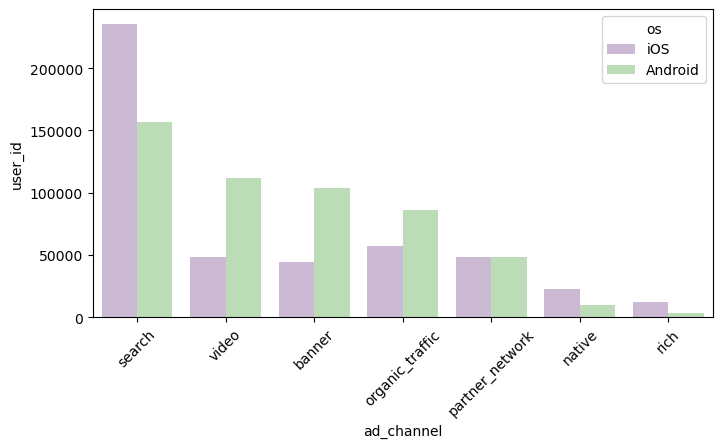

In [354]:
plt.figure(figsize=(8,4))

sns.barplot(
    x='ad_channel', 
    y='user_id', 
    data=os, 
    palette='PRGn',
    hue='os');
plt.xticks(rotation=45);

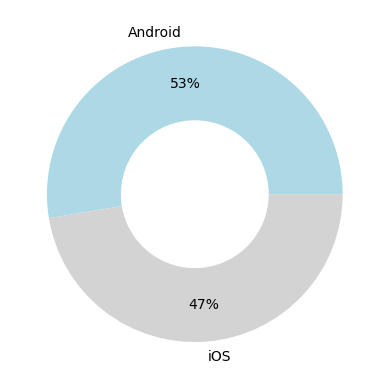

In [382]:
plt.pie(data.groupby(['os'], as_index=False)['user_id'].count().sort_values(by=['user_id'], ascending=False).user_id,
       labels=data.groupby(['os'], as_index=False)['user_id'].count().sort_values(by=['user_id'], ascending=False).os,
       colors=['lightblue', 'lightgrey'],
       autopct='%.0f%%',
       wedgeprops=dict(width=0.5),
       pctdistance=0.75);

#### Вывод

В целом, количество пользователей Android и IOS примерно равно, Android немного выше. Есть каналы, в которых преобладает Android (video, banner, organic_traffic) и есть те, в которых преобладает IOS (search,native,reach), в канале partner network значения одинаковы